In [1]:
import pandas as pd
import numpy as np

In [2]:
import json
with open('cora_features', 'r')  as f:
    features = json.load(f)

In [3]:
len(features.keys())

2708

In [4]:
edges = pd.read_csv('cora_edges.csv')

In [5]:
edges2 = edges[(edges.Source.isin(np.array(list(features.keys())).astype(int)))&(edges.Target.isin(np.array(list(features.keys())).astype(int)))]

In [6]:
edges2

Target   Source
0           35     1033
1           35   103482
2           35   103515
3           35  1050679
4           35  1103960
...        ...      ...
10551   853155   853115
10552   853155   853116
10553  1140289   853118
10554   853118   853155
10555  1155073   954315

[10556 rows x 2 columns]

In [7]:
old_indexes = np.array(list(features.keys())).astype(int)
new_indexes = range(len(old_indexes))
voc1 = dict(zip(old_indexes, new_indexes))
voc2 = dict(zip(new_indexes, old_indexes))

In [8]:
edges2.Source = edges2.Source.apply(lambda x: voc1[x])
edges2.Target = edges2.Target.apply(lambda x: voc1[x])

In [9]:
edges2

Target  Source
0         163     402
1         163     659
2         163    1696
3         163    2295
4         163    1274
...       ...     ...
10551    1902    1885
10552    1902    1886
10553    2258    1887
10554    1887    1902
10555    1686     837

[10556 rows x 2 columns]

In [10]:
features2 = dict(zip(new_indexes, features.values()))

In [11]:
edges2

Target  Source
0         163     402
1         163     659
2         163    1696
3         163    2295
4         163    1274
...       ...     ...
10551    1902    1885
10552    1902    1886
10553    2258    1887
10554    1887    1902
10555    1686     837

[10556 rows x 2 columns]

In [12]:
format_features = list(features2.values())

In [13]:
len(format_features)

2708

In [14]:
all_pairs = edges2.groupby('Source').Target.apply(list)

In [15]:
def bfs(graph, start):
    summa=0
    path = []
    hops = []
    hops.append([start])
    next_hop = []
    for i in range(4):
        for i in range(len(hops[-1])):
            vertex = hops[-1][i]
            if i==0 and vertex not in path:
                path.append(vertex)
                next_hop = list(set(graph[vertex])-set(path))
                
            elif vertex not in path:
                path.append(vertex)
                next_hop += list(set(graph[vertex])-set(path))
        next_hop = list(pd.Series(next_hop, dtype=pd.Int64Dtype())[~pd.Series(next_hop, dtype=pd.Int64Dtype()).isin(path)].drop_duplicates())
        summa+=(len(next_hop))
        if next_hop:
            hops.append(next_hop)
        if pd.Series(next_hop, dtype=pd.Int64Dtype()).isin(path).astype(int).sum()==len(next_hop):
            break
#     return(summa)
    return path

In [16]:
q = 0
for i in range(2500):
    q += bfs(all_pairs, i)
q/250

TypeError: unsupported operand type(s) for +=: 'int' and 'list'

In [17]:
import torch
from torch_geometric.data import Data

In [18]:
#Создание графа для нейронной сети
from torch_geometric.utils import remove_isolated_nodes
def create_graph(seq, el_num):
    element = seq[el_num]
    new_seq = seq[:el_num]
    sorted_new_seq = np.sort(new_seq)
    order = [np.where(new_seq==x)[0].item() for x in sorted_new_seq]
    res = np.array(pd.Series(seq[:el_num]).isin(all_pairs[element]).astype(int))
    res = res[order]
    edge_index = torch.tensor(np.array(edges2[(edges2.Source.isin(new_seq)) & (edges2.Target.isin(new_seq))]))
    q = remove_isolated_nodes(edge_index)
    edge_index = torch.tensor(q[0])
    temp = np.zeros(len(format_features))
    temp[:len(q[2])] = q[2]
    x = torch.tensor(format_features)[temp.astype(bool)].float()
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    node_features = format_features[element]
    return(data, res, node_features)

In [19]:
def get_min_len(seq):
    x = [len(x) for x in seq]
    return(min(x))

In [20]:
#Создание батча графов для нейронной сети
def create_batch(sequences):
    el_num = get_min_len(sequences)-1
    graphs = []
    results = []
    features = []
    for i in sequences:
        info = create_graph(i, el_num)
        graphs.append(info[0])
        results.append(info[1])
        features.append(info[2])
    return(graphs, results, features)

In [21]:
path0 = bfs(all_pairs,111)
path1 = bfs(all_pairs,122)

In [22]:
create_batch([path0, path1])

([Data(edge_index=[2, 192], x=[77, 1434]),
  Data(edge_index=[2, 222], x=[77, 1434])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [23]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch_geometric.nn import avg_pool, global_add_pool
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, DataLoader, NeighborSampler
from torch.nn import BatchNorm1d, Linear

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1434, 1000)
        self.conv2 = GCNConv(1000, 700)
        self.conv3 = GCNConv(700, 250)
        self.graph_to_h0 = nn.Linear(1434, 150)
        self.graph_to_c0 = nn.Linear(1434, 150)
        self.lstm = nn.LSTM(250, 150, batch_first = True) 
        self.logits = nn.Linear(150, 1)
    def forward(self, data, features):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        num_graphs = data.num_graphs
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = x.view((num_graphs,int(len(x)/num_graphs),250))
        initial_cell = self.graph_to_c0(features)
        initial_hid = self.graph_to_h0(features)
        state = (initial_cell[None], initial_hid[None])
        lstm_out, state = self.lstm(x, state)
        logits = self.logits(lstm_out)
        res = F.sigmoid(logits)
        return res
        

In [25]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = GCNConv(1434, 1000)
        self.conv2 = GCNConv(1000, 700)
        self.conv3 = GCNConv(700, 250)
        self.convert = nn.Linear(250,100)
        self.convert1 = nn.Linear(100,50)
        self.convert2 = nn.Linear(50,25)
        self.convert3 = nn.Linear(25,1)
    def forward(self, data, features):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        num_graphs = data.num_graphs
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = x.view((num_graphs,int(len(x)/num_graphs),250))
        x = self.convert(x)
        x = F.relu(x)
        x = self.convert1(x)
        x = F.relu(x)
        x = self.convert2(x)
        x = F.relu(x)
        x = self.convert3(x)
        return x
        

In [26]:
class Net3(torch.nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = GCNConv(1434, 1000)
        self.conv2 = GCNConv(1000, 700)
        self.conv3 = GCNConv(700, 250)
        self.convert = nn.Linear(1684,100)
        self.convert1 = nn.Linear(100,50)
        self.convert2 = nn.Linear(50,25)
        self.convert3 = nn.Linear(25,1)
    def forward(self, data, features):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        num_graphs = data.num_graphs
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = x.view((num_graphs,int(len(x)/num_graphs),250))
        features = torch.tensor([[a]*len(x[0]) for a in features.tolist()])
        x = torch.cat((x,features), dim=2)
        x = self.convert(x)
        x = F.relu(x)
        x = self.convert1(x)
        x = F.relu(x)
        x = self.convert2(x)
        x = F.relu(x)
        x = self.convert3(x)
        return x

In [27]:
model = Net()

In [28]:
loader = DataLoader(create_batch([path0, path1])[0], batch_size=2)

In [29]:
def computeLoss(network, batch, batch_size):
    info = create_batch(batch)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    loss = nn.BCELoss()
    loss_val = loss(preds, res.float())
#     del node_features
#     del res
#     del loader
#     del q
    torch.cuda.empty_cache()
    return(loss_val)

In [30]:
#Взвешанная бинарная кроссэнтропия, которая не работает ни с какими весами
def computeLoss(network, batch, batch_size):
    info = create_batch(batch)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    weight = torch.tensor([[(len(x)-float(sum(x)))/float(sum(x))] for x in res])
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    loss = nn.BCEWithLogitsLoss(weight =weight)
    loss_val = loss(preds, res.float())
#     del node_features
#     del res
#     del loader
#     del q
    torch.cuda.empty_cache()
    return(loss_val)

In [31]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# device = torch.device('cpu')
model = Net3()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=5e-4)

In [32]:
q = 0
for i in all_pairs.keys():
    mas = bfs(all_pairs, i)
    if len(mas)>100:
        np.save('new_cora_4_'+str(q), mas)
        q+=1
print(q)

1182


In [33]:
np.load('new_cora_4_1.npy')

array([   3,  601,  197,  463,  552,  565,  611, 1741,  633,  749,  295,
        477,  483,  564,  333,    2,  644,  653,   16,  277,  412,  671,
        548,  167,  554,  298,  173,  559,  688,  305,  306,  691,  311,
         57,   60,  446,  575,  451,  455,  210,  723,  466,   85,  472,
        473,  220,   92,  738,  621,  239,  367,  370,  374,  636, 1540,
        773, 1546,  523,  283,   34, 1316,  294, 1585,  566, 1859, 2628,
       2629, 2118,  842, 1616,   82, 2642, 1373, 1376, 1378,  103, 2672,
        882,  118, 1401,  128,  385, 2442, 1676,  910,  410, 1438, 1440,
       1957, 2472,  425, 2480, 2485, 1975, 1213, 1727,  465,  478, 2027,
        492,  244, 1012, 1782,  502, 1529, 1790, 2050,  899,  386, 1668,
        133, 1935, 2325,   28, 1564,  413, 1315, 2340,  938, 2352,  179,
       2230, 1079,  579, 1732, 2501, 1352, 2505, 2378,  716,  718,  719,
       1103, 2385, 1488, 2260, 1493, 1755, 1116, 1499,  608,  864, 1763,
       2540,  368, 1265, 2676,  511, 1841, 1459,  4

In [34]:
#чтение нагенерированных bfs последовательностей для обучения.
train = []
test = []
for i in range(500):
        train.append(np.load('new_cora_4_'+str(i)+'.npy',allow_pickle=True))
for i in range(500,1000):
        test.append(np.load('new_cora_4_'+str(i)+'.npy',allow_pickle=True))
train = np.array(train)
test = np.array(test)

In [35]:
#функция, которая выводит предикт, и показывает, насколько он адекватный
def get_pred(network, batch, batch_size):
    info = create_batch(batch)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = F.sigmoid(network.forward(q, node_features.float()).squeeze(-1))
    return(preds, res)

In [36]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

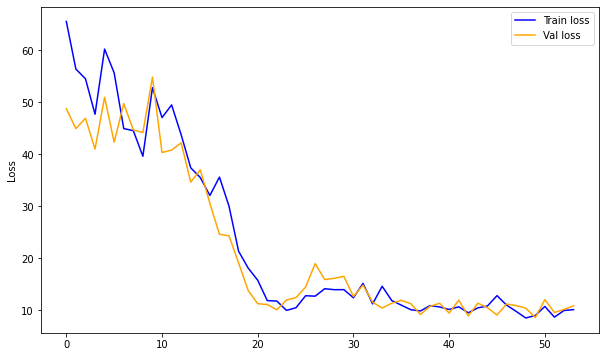

(tensor([[2.9720e-02, 4.9070e-02, 1.9749e-02, 4.6935e-02, 4.5200e-02, 1.8692e-02,
         7.8214e-02, 6.8970e-03, 1.0517e-09, 7.1165e-02, 6.0064e-02, 7.6063e-03,
         4.1188e-02, 2.4861e-02, 5.9908e-03, 6.4611e-02, 1.0632e-02, 8.0558e-02,
         4.8793e-02, 3.4376e-02, 7.7393e-02, 8.2298e-02, 1.0036e-01, 2.5819e-02,
         8.1633e-02, 4.3724e-02, 4.7812e-02, 3.0170e-02, 2.9923e-02, 5.0479e-02,
         3.3910e-02, 3.4398e-02, 4.0687e-02, 1.4389e-05, 1.1837e-01, 5.4321e-02,
         1.1903e-01, 4.5211e-02, 3.1207e-02, 2.5333e-02, 5.9260e-04, 4.7640e-02,
         8.7422e-02, 3.5861e-02, 1.0730e-02, 7.8860e-02, 3.5861e-02, 7.8461e-02,
         4.0874e-02, 4.3286e-02, 3.5581e-02, 2.3856e-02, 3.2675e-02, 4.3970e-02,
         6.9292e-03, 1.0518e-01, 4.3098e-02, 1.0889e-01, 2.9026e-03, 6.4867e-02,
         2.7126e-02, 7.9990e-02, 7.1926e-02, 1.9843e-02, 2.0020e-02, 6.6296e-03,
         2.0628e-04, 6.7802e-02, 7.3953e-02, 9.2391e-02, 4.1815e-02, 6.0720e-03,
         2.0730e-03, 4.8102

KeyboardInterrupt: 

In [37]:
num_epoch = 100
n_batches_per_epoch = 1
batch_size = 30
n_validation_batches = 1
train_losses = []
val_losses = []
for epoch in range(num_epoch):
    train_loss= 0
    val_loss = 0
    model.train(True)
    order = np.random.permutation(len(train))
    order2 = np.random.permutation(len(test))
    for i in range(n_batches_per_epoch):
        optimizer.zero_grad()
        batch_indexes = order[0:0+batch_size]
        x_batch = train[batch_indexes]
        x_batch = list(np.array(x_batch))
        loss_value = computeLoss(model, x_batch, batch_size)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
    train_loss /= (n_batches_per_epoch)
    train_losses.append(train_loss)
    model.train(False)
    for _ in range(n_batches_per_epoch):
        batch_indexes = order2[0:0+batch_size]
        x_batch = test[batch_indexes]
        x_batch = list(np.array(x_batch))
        loss_value = computeLoss(model, x_batch, batch_size)
        val_loss += loss_value.item()
    val_loss /= (n_validation_batches)
    val_losses.append(val_loss)
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    print(get_pred(model, [test[10], test[40]],2))

In [38]:
get_pred(model, [np.array(bfs(all_pairs, 133))[:5]], 1)[0]

tensor([[0.0019, 0.0042, 0.0019, 0.0043]], grad_fn=<SigmoidBackward>)

In [39]:
def get_dov_int(arr):
    mean = arr.mean()
    st = torch.std(arr)
    res = mean+1.96*st/np.sqrt(len(arr))
    return(res.item())

In [87]:
get_dov_int(get_pred(model, [np.array(bfs(all_pairs, 111))[:100]], 1)[0])

0.07428894937038422

In [88]:
def get_aj_vector(network, batch, batch_size):
    info = create_batch(batch)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = F.sigmoid(network.forward(q, node_features.float()).squeeze(-1))
    max_val = get_dov_int(preds)
    if (preds[:]>=max_val).int().sum()==0:
        preds[:,preds.argmax()] = 1
    else:
        print((preds>=max_val).int())
    preds = (preds>max_val).int()
    return preds

In [89]:
get_aj_vector(model, [np.array(bfs(all_pairs, 133))[:5]], 1)

tensor([[0, 0, 0, 1]], dtype=torch.int32)

In [90]:
def max_hop_diff(graph, start):
    summa=0
    path = []
    hops = []
    hops.append([start])
    next_hop = [1]
    this_hop_len = 0
    max_diff = 0
    while next_hop:
        this_hop_len = len(next_hop)
        for i in range(len(hops[-1])):
            vertex = hops[-1][i]
            if i==0 and vertex not in path:
                path.append(vertex)
                next_hop = list(set(graph[vertex])-set(path))
                
            elif vertex not in path:
                path.append(vertex)
                next_hop += list(set(graph[vertex])-set(path))
        next_hop = list(pd.Series(next_hop, dtype=pd.Int64Dtype())[~pd.Series(next_hop, dtype=pd.Int64Dtype()).isin(path)].drop_duplicates())
        if len(next_hop)+this_hop_len>max_diff:
            max_diff =  len(next_hop)+this_hop_len
        if next_hop:
            hops.append(next_hop)
        if pd.Series(next_hop, dtype=pd.Int64Dtype()).isin(path).astype(int).sum()==len(next_hop):
            break
    
#     return max_diff
    return(path)

In [91]:
#Максимальная сумма длинн двух соседствующих хопов: когда восстанавливаем граф не нужно смотреть большее кол-во узлов, добавленныхв граф
# maxl = 0
# for i in all_pairs.keys():
#     q = max_hop_diff(all_pairs, i)
#     if q>=maxl:
#         maxl = q
maxl

NameError: name 'maxl' is not defined

In [163]:
data = create_graph(max_hop_diff(all_pairs, 1),350)[0]
f = data.x
edges = data.edge_index.t()

In [164]:
edges.t()[0].max()

tensor(349)

In [166]:
order = max_hop_diff(all_pairs, 1)[350:]

In [ ]:
k = 0
for i in order:
    nf = torch.tensor(format_features[i])
    edge_index = edges
    x = f
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    loader = DataLoader([data], batch_size=1)
    for q in loader:
        preds = F.sigmoid(model.forward(q, nf.unsqueeze(0).float())).squeeze(-1)
    max_val = get_dov_int(preds)
    if (preds[:]>=max_val).int().sum()==0:
        preds[:,preds.argmax()] = 1
    preds = (preds>max_val).int()
    temp = (preds==1).nonzero()
    temp[:,0]=x.shape[0]
    temp = torch.cat((temp,temp[:,[1,0]]), dim=0)
    edges = torch.cat((edges, temp), dim=0)
    f = torch.cat((f, nf.unsqueeze(0).float()))
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [96]:
edges.shape

torch.Size([13432, 2])

In [97]:
res = edges.numpy()

In [98]:
np.save('full_graph.npy', res)

In [99]:
r = np.load('full_graph.npy')

In [100]:
r.shape

(13432, 2)

In [101]:
import networkx as nx

In [102]:
G=nx.Graph()

In [103]:
G.add_edges_from(r)

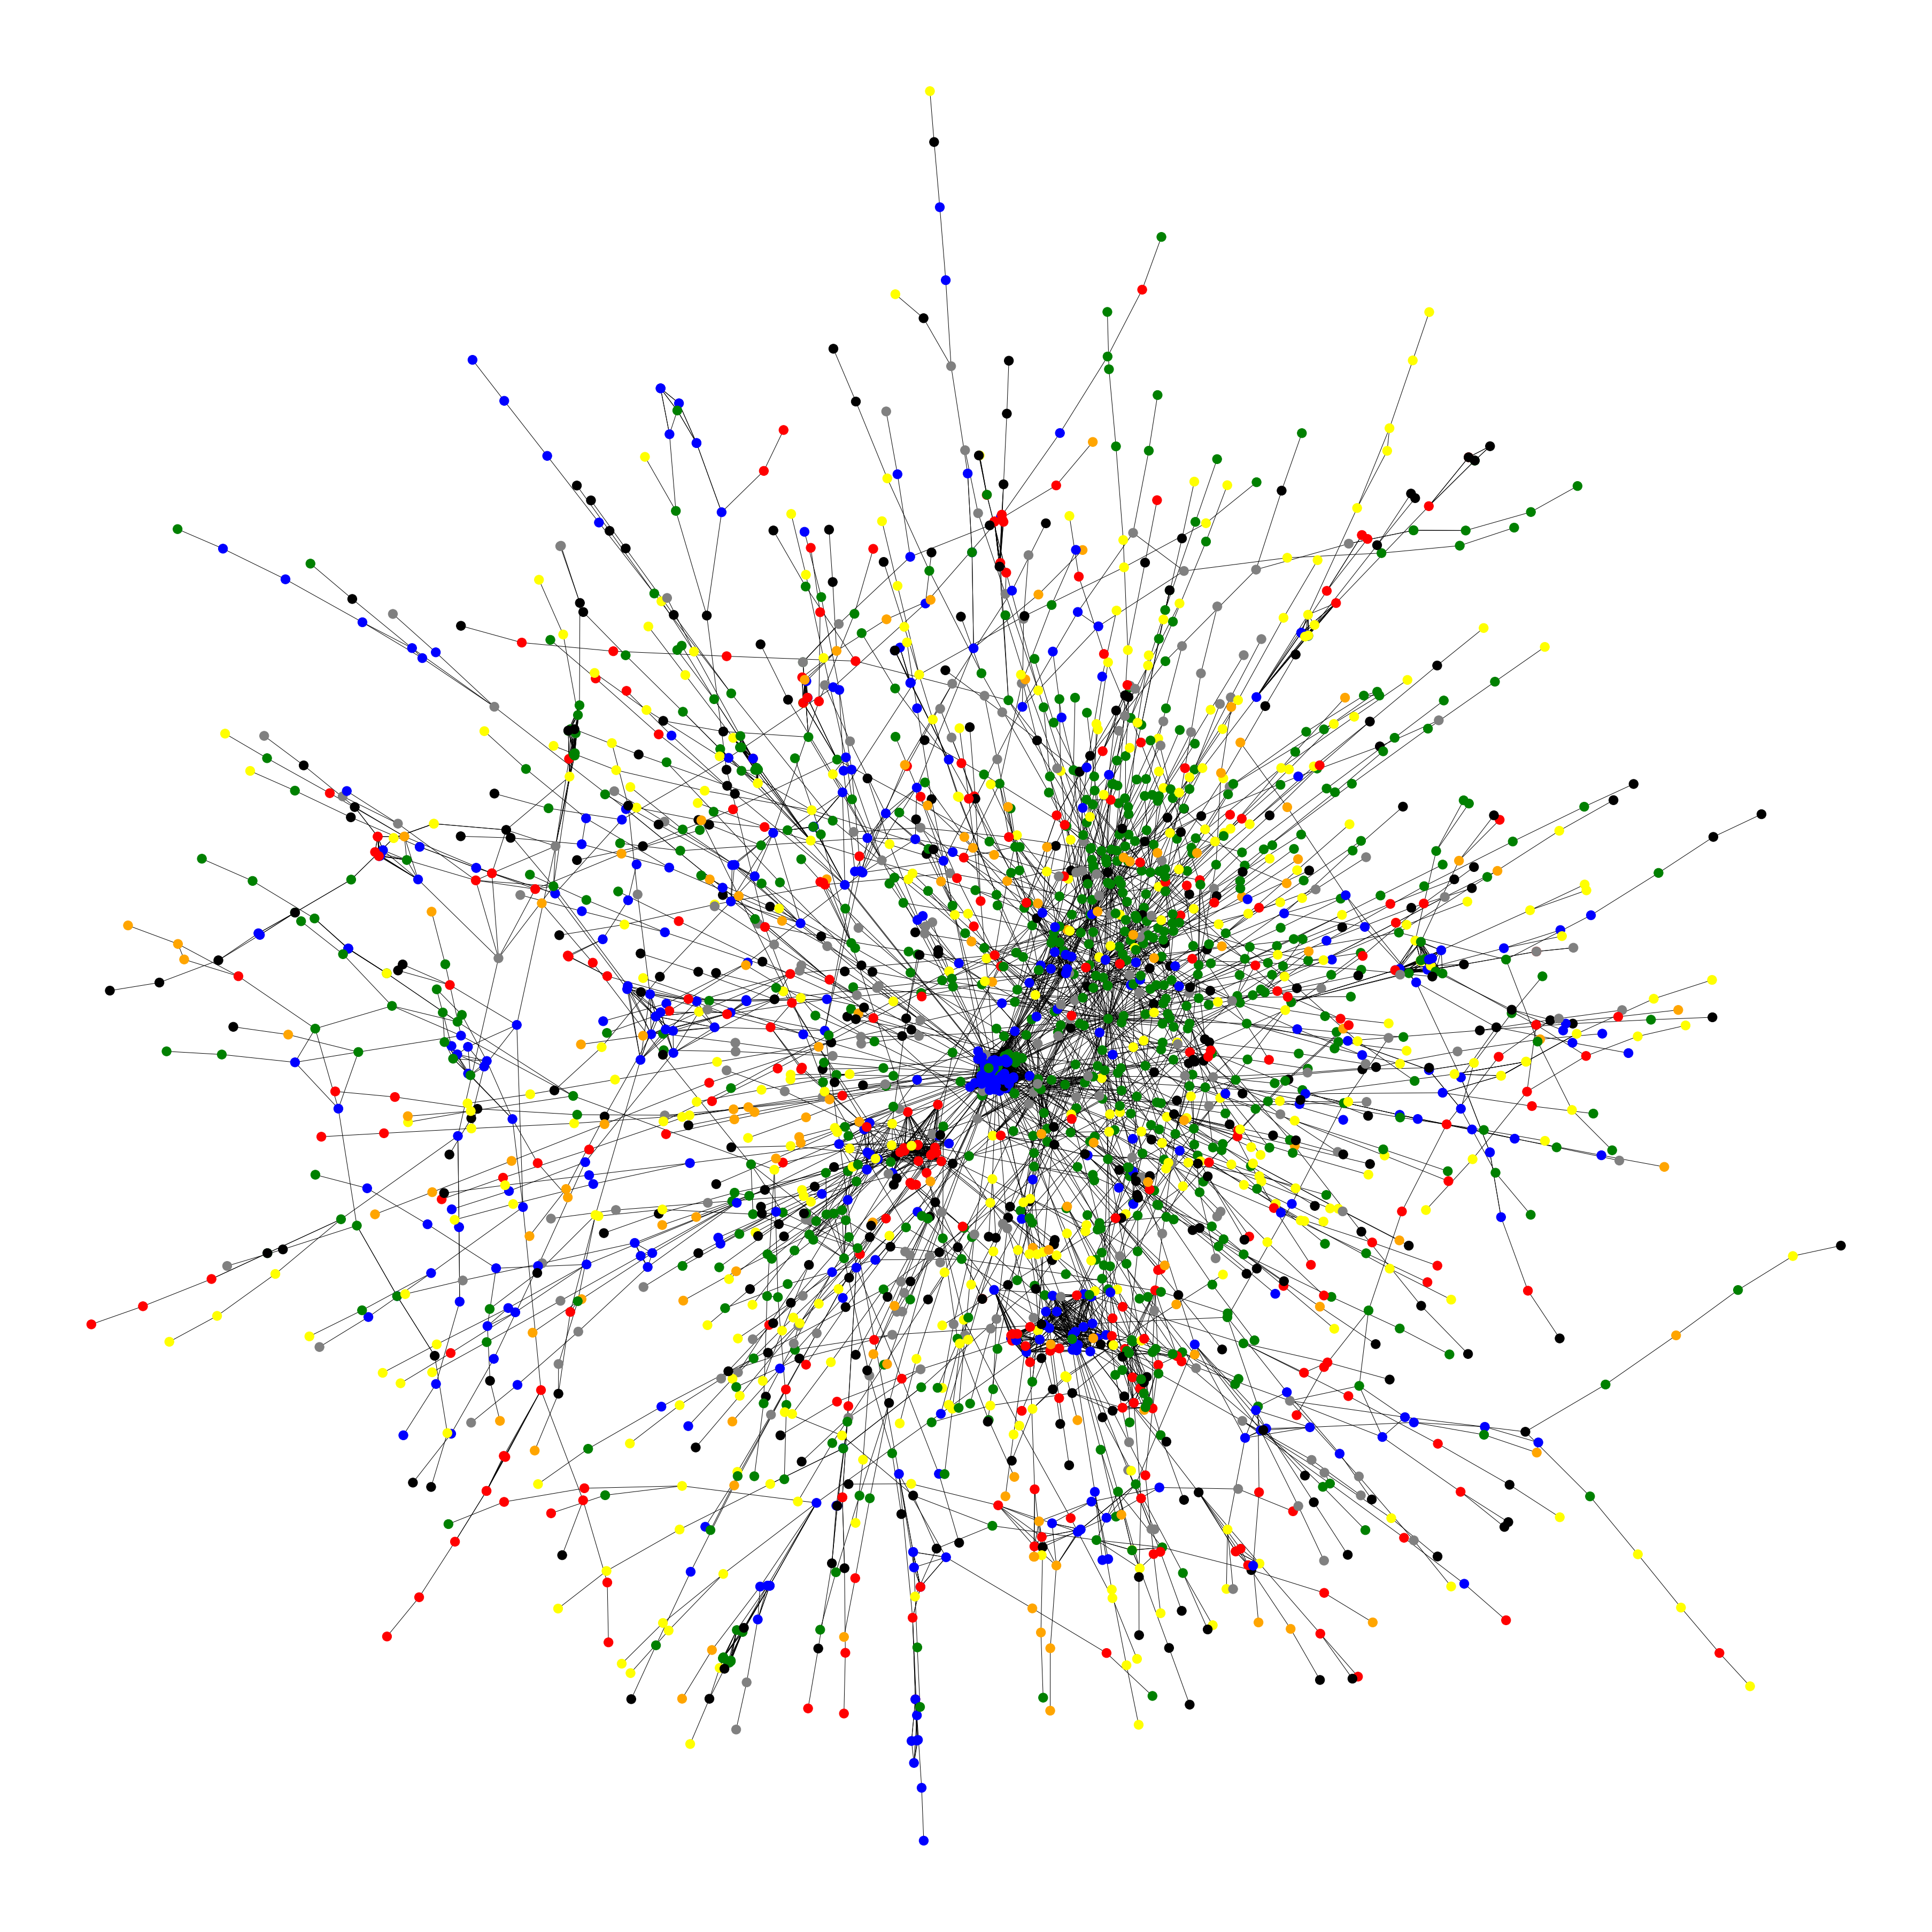

In [107]:
plt.figure(figsize = (50, 50))
nx.draw(G, node_color=labs)

In [104]:
[f[:, -1].max()]

[tensor(6.)]

In [105]:
colours = {0:'red', 1:'blue', 2:'green',3:'yellow', 4:'grey', 5:'orange',6:'black'}

In [106]:
labs = [colours[x] for x in f[:,-1].int().tolist()]

In [134]:
nodes = pd.DataFrame(edges.t()[0]).rename(columns = {0:'node'})
nodes['degree'] = 1
degrees = nodes.groupby('node').count()

In [138]:
degrees['coun'] = 1
count = degrees.groupby('degree').count().coun
degree = count.index


In [142]:
import seaborn as sns

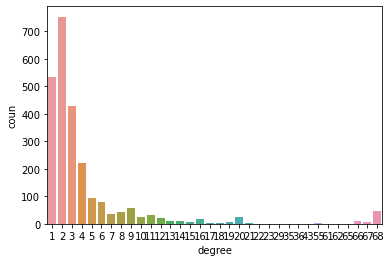

In [145]:
sns.barplot(x=degree, y=count)

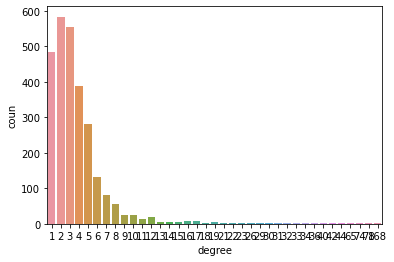

In [162]:
nodes = pd.DataFrame(list(edges2.Target)).rename(columns={0:'node'})
nodes['degree'] = 1
degrees = nodes.groupby('node').count()
degrees['coun'] = 1
count = degrees.groupby('degree').count().coun
degree = count.index
sns.barplot(x=degree, y=count)

In [156]:
len(create_batch([bfs(all_pairs, 2)])[0][0].edge_index[0])

1182

In [161]:
list(edges2.Target)

[163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 163,
 168

In [934]:
k = 0
for i in order:
    nf = torch.tensor(format_features[i])
    edge_index = edges
    x = f
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    loader = DataLoader([data], batch_size=1)
    for q in loader:
        preds = F.sigmoid(model.forward(q, nf.unsqueeze(0).float())).squeeze(-1)
    max_val = get_dov_int(preds)
    if (preds[:]>=max_val).int().sum()==0:
        preds[:,preds.argmax()] = 1
    preds = (preds>max_val).int()
    if len(preds>=700):
        preds[:,:-700] = 0
    temp = (preds==1).nonzero()
    temp[:,0]=x.shape[0]
    temp = torch.cat((temp,temp[:,[1,0]]), dim=0)
    edges = torch.cat((edges, temp), dim=0)
    f = torch.cat((f, nf.unsqueeze(0).float()))
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 